In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from cmath import sinh, tanh, cosh
import pandas as pd

%matplotlib inline

In [2]:
SAMPLE_SIZE = 300  # samples
NETA_RANGE = (0.7, 0.9)
DELTA_RANGE = (0.08, 0.1)
N_RANGE = (200, 300)
PITCH_RANGE = (200, 300)
LAMBDA_MAX_RANGE = (1500, 2500)
LAMBDA_RANGE = (500, 3500)
NO_OF_VARIABLES = 5

In [3]:
def P(neta, delta, N, pitch, x, x0):
    """
    Reflected power function
    neta  : percentage of power in the core
    delta : difference of refreactive index of the core and cladding
    N     : number of grating
    pitch : period of the grating
    x     : wavelength
    x0    : the wavelength at which power is maximum
    
    returns : power value at 'x'
    """
    sqrt = lambda v: complex(v, 0)**0.5

    g = (1.0/(neta*delta))*((x/x0)-1)
    g = g**2

    theta = neta*delta*N*pitch*sqrt(1-g)/x

    nr = sinh(theta)**2
    dr = (cosh(theta)**2)-g

    return abs(nr/dr)


def reflected_samples(neta:float, delta:float, N:float, pitch:float, x0:float):
    """
    returns : numpy array 
    """
    
    # uniformly sample the function
    # generate sample points
    d = (LAMBDA_RANGE[1] - LAMBDA_RANGE[0])/SAMPLE_SIZE
    x = LAMBDA_RANGE[0]
    
    Y = []
    
    neta = NETA_RANGE[0]+(NETA_RANGE[1]-NETA_RANGE[0])*neta
    delta = DELTA_RANGE[0]+(DELTA_RANGE[1]-DELTA_RANGE[0])*delta
    N = N_RANGE[0]+(N_RANGE[1]-N_RANGE[0])*N
    pitch = PITCH_RANGE[0]+(PITCH_RANGE[1]-PITCH_RANGE[0])*pitch
    x0 = LAMBDA_MAX_RANGE[0]+(LAMBDA_MAX_RANGE[1]-LAMBDA_MAX_RANGE[0])*x0

    for _ in range(SAMPLE_SIZE):
        Y.append(P(neta, delta, N, pitch, x, x0))
        x = x + d
    
    return np.array(Y)

In [4]:
bwd = keras.models.load_model('bwd_64x64x64x32_50epochs_4e-4_adam_200000')
bwd.trainable = False

In [5]:
bwd.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bwd_input_layer (InputLayer) [(None, 300)]             0         
_________________________________________________________________
bwd_hidden_layer1 (Dense)    (None, 64)                19264     
_________________________________________________________________
batch_normalization_20 (Batc (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer2 (Dense)    (None, 64)                4160      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
bwd_hidden_layer3 (Dense)    (None, 64)                4160      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256 

In [6]:
with np.load('data_300_samples200000.npz') as data:
    x_test = data['Xtest']  # design parameters
    y_test = data['Ytest']  # function samples

In [8]:
x_pred = bwd.predict(y_test)  # bwd predicts design parameters given function samples

In [9]:
print(f'shape of predictions: {x_pred.shape}')
print(f'shape of x_test: {x_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of predictions: (40000, 5)
shape of x_test: (40000, 5)
shape of y_test: (40000, 300)


In [9]:
actual = [reflected_samples(x[0], x[1], x[2], x[3], x[4]) for x in x_test]
predicted = [reflected_samples(x[0], x[1], x[2], x[3], x[4]) for x in x_pred]

/home/ninja/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


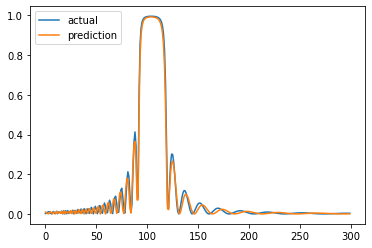

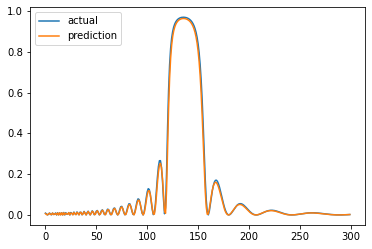

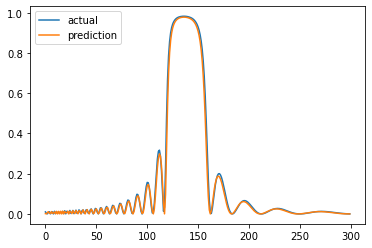

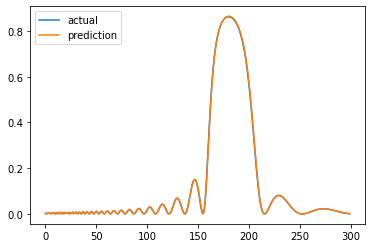

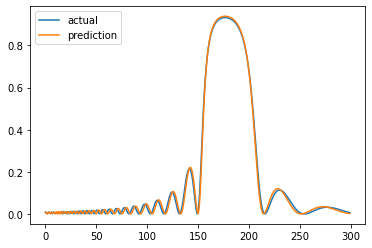

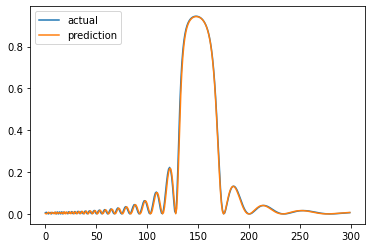

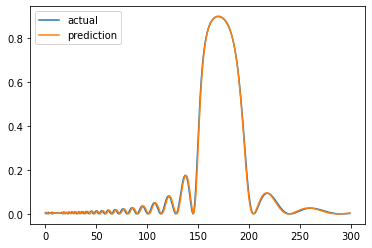

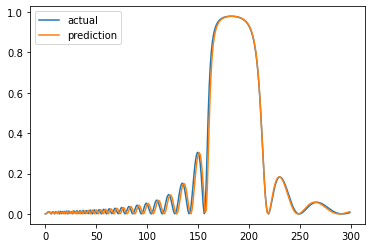

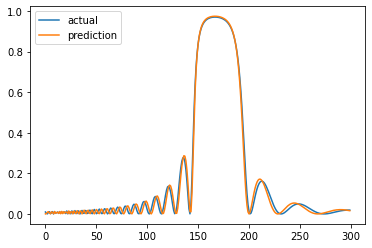

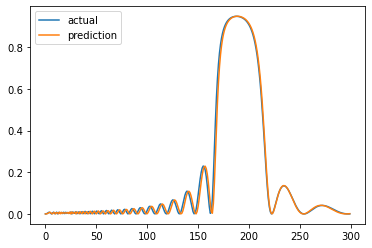

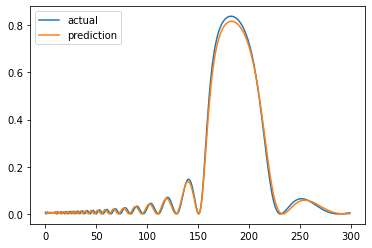

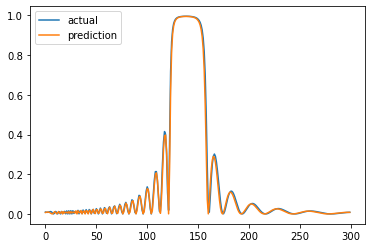

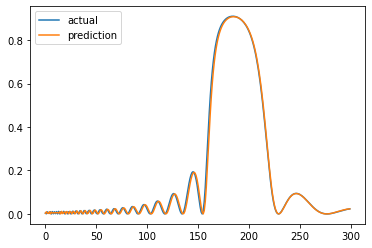

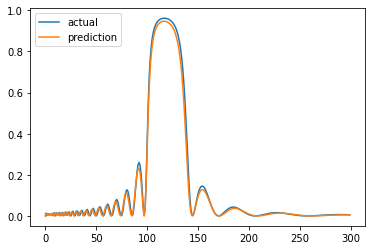

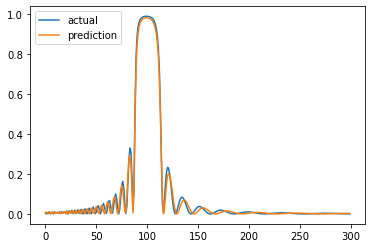

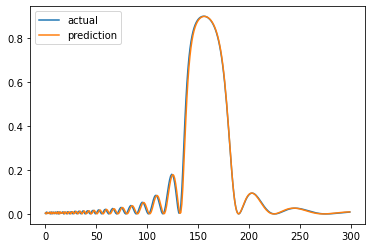

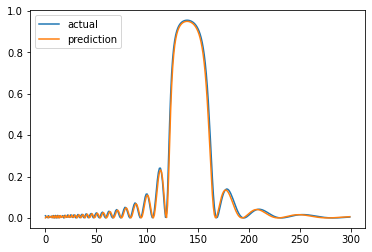

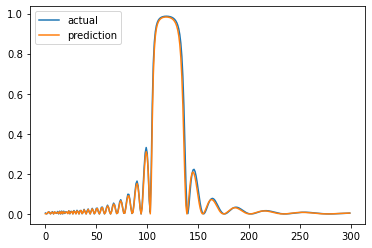

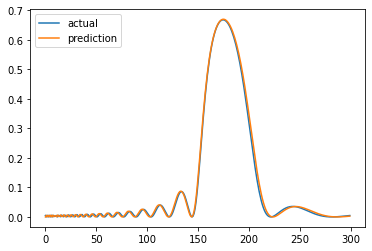

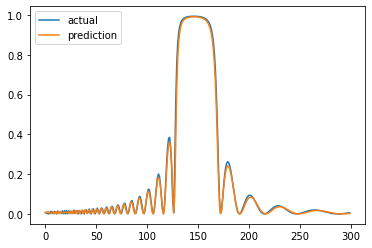

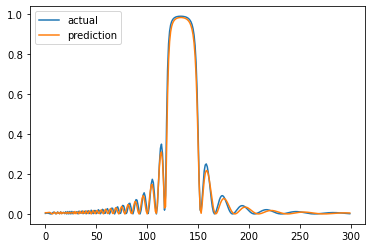

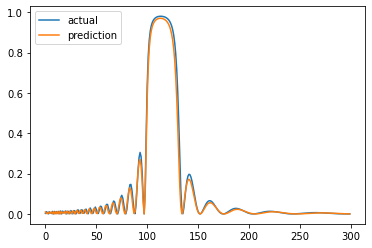

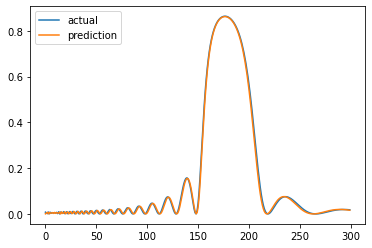

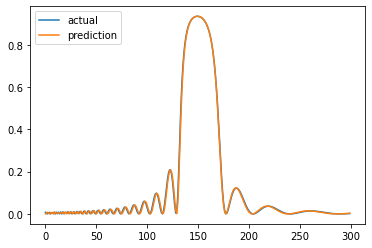

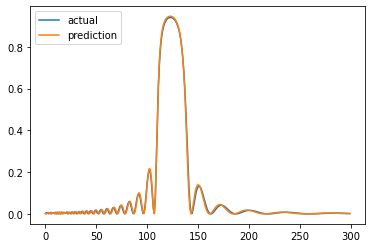

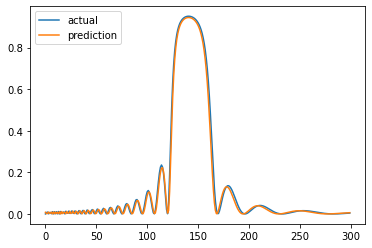

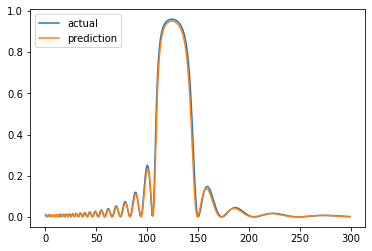

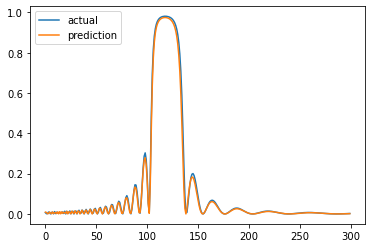

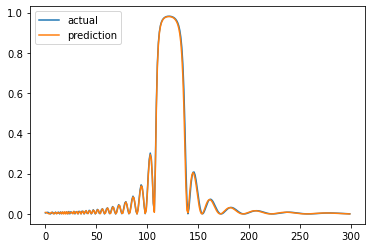

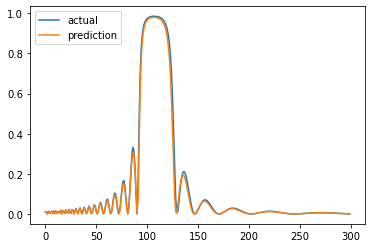

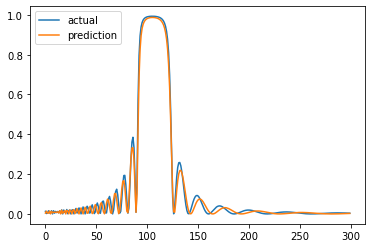

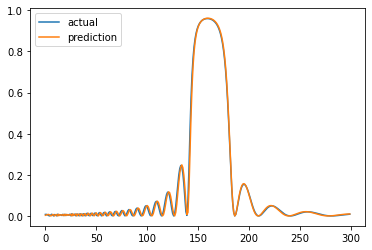

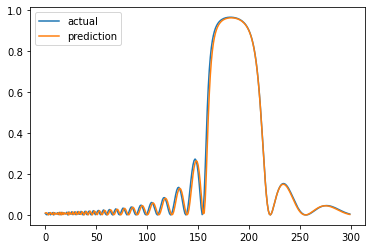

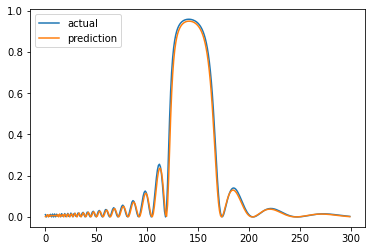

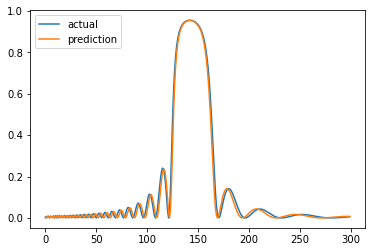

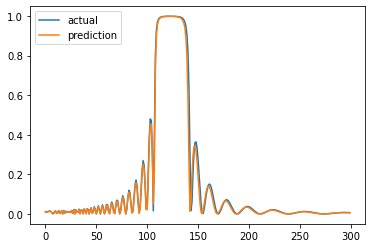

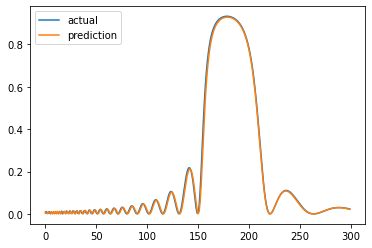

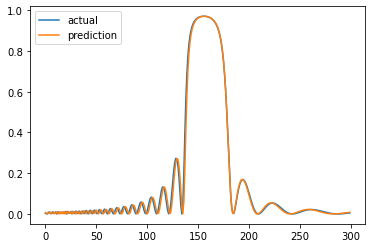

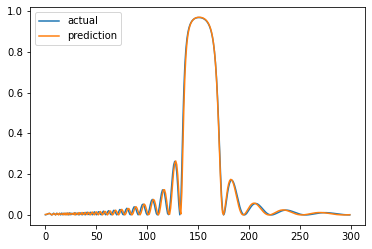

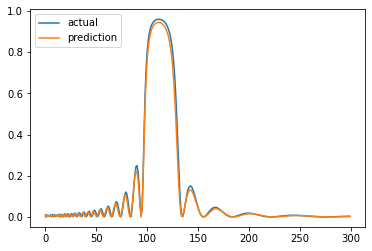

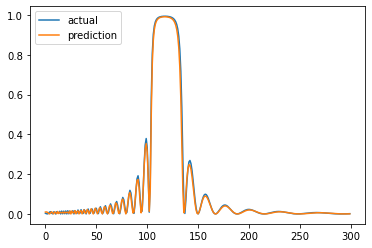

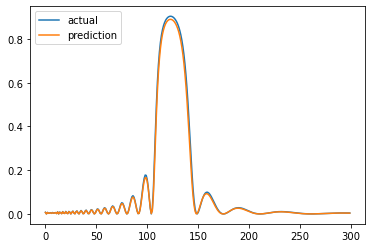

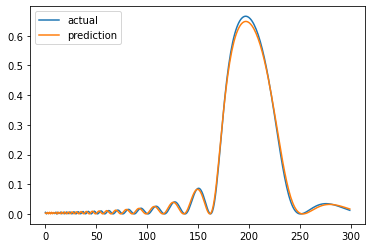

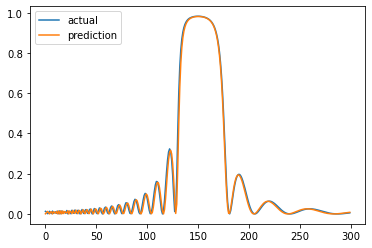

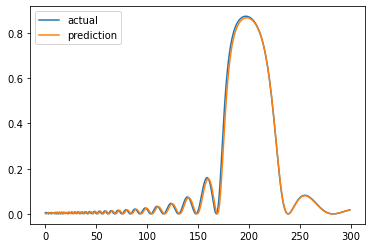

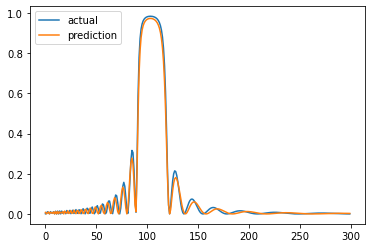

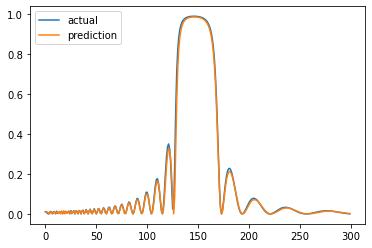

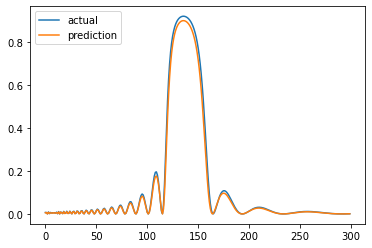

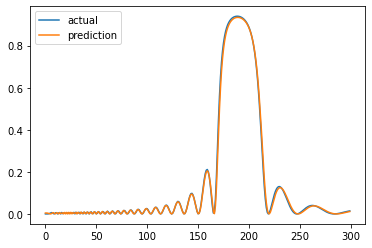

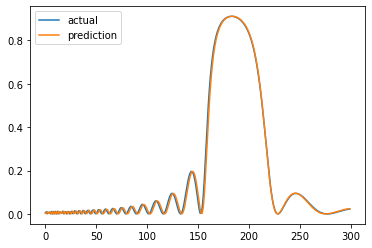

In [12]:
random_samples = [random.randint(0, len(predicted)-1) for _ in range(50)]
for i in random_samples:
    fig, ax = plt.subplots()
    x = x_test[i]
    ax.plot(reflected_samples(x[0], x[1], x[2], x[3], x[4]))
    x = x_pred[i]
    ax.plot(reflected_samples(x[0], x[1], x[2], x[3], x[4]))
    
    ax.legend(['actual', 'prediction'], loc='upper left')

In [4]:
# test for fwd model
fwd = keras.models.load_model('fwd_64x64x64x64x60_50epochs300000samples_56%_adam')

In [6]:
# fwd model takes design paramets and outputs function samples
predictions = fwd.predict(x_test)

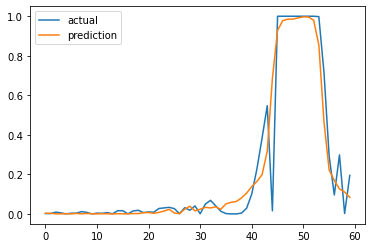

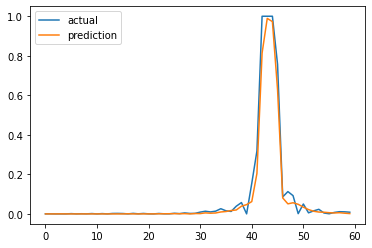

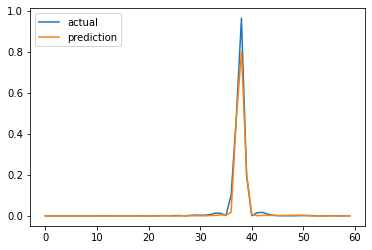

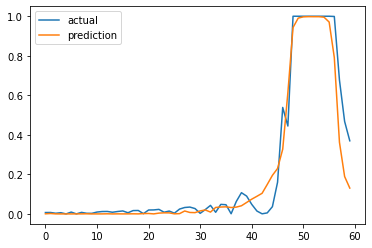

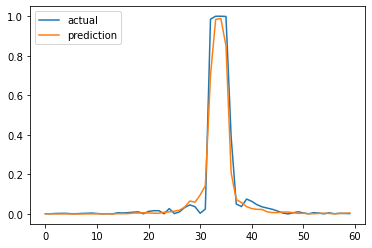

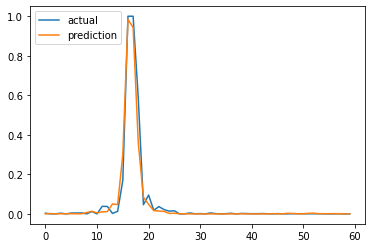

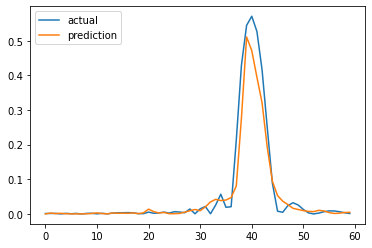

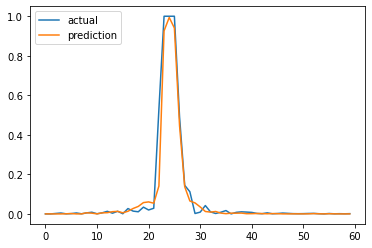

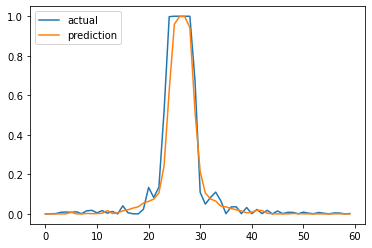

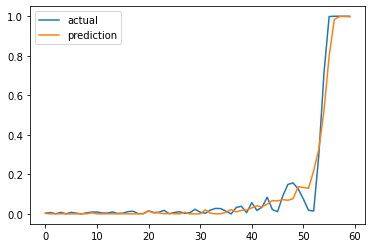

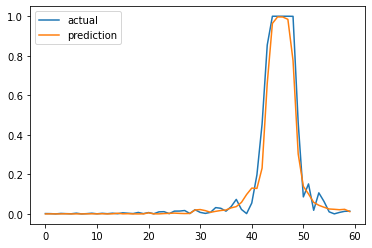

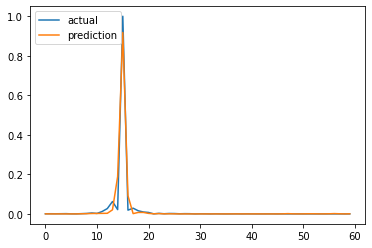

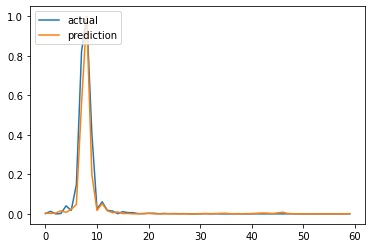

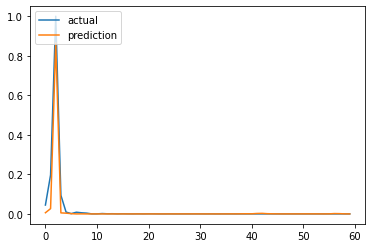

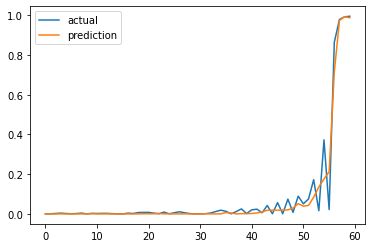

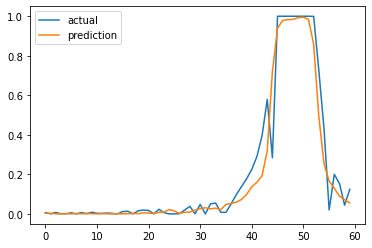

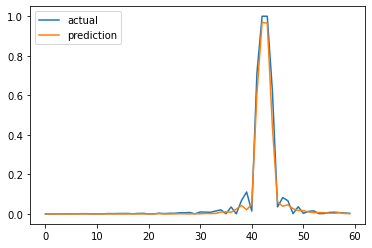

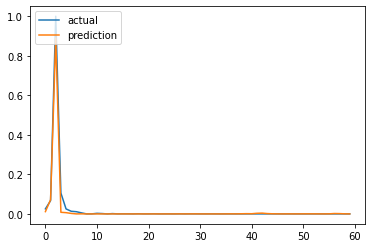

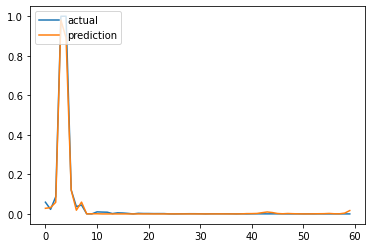

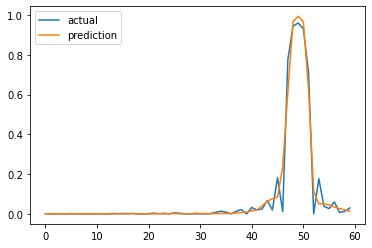

In [8]:
for i in range(5, 25):
    fig, ax = plt.subplots()
    ax.plot(y_test[i])
    ax.plot(predictions[i])

    ax.legend(['actual', 'prediction'], loc='upper left')

In [3]:
import pandas as pd

In [5]:
df = pd.read_pickle('./vsplots/data.pkl')

In [6]:
df

,index,act-neta,act-delta,act-N,act-pitch,act-lambdaB,pred-neta,pred-delta,pred-N,pred-pitch,pred-lambdaB
0,38374,0.808484,0.080590,220.534562,218.172800,1906.556562,0.721042,0.085400,209.675440,225.574866,1906.241000
1,39271,0.803451,0.084880,270.663008,286.460655,1713.525434,0.742549,0.088022,267.842650,288.014847,1710.507303
2,11521,0.786278,0.092740,202.284995,202.249918,2438.791591,0.828719,0.084946,204.302222,203.070712,2462.458491
3,34824,0.795440,0.091893,276.214391,233.401893,2488.745712,0.785645,0.090340,228.687358,285.720778,2499.962747
4,24518,0.864630,0.086690,296.924270,287.328776,1671.359288,0.782447,0.091796,279.008543,292.106235,1669.269860
...,...,...,...,...,...,...,...,...,...,...,...
995,12644,0.823729,0.081457,294.223681,263.525334,2214.341882,0.793660,0.083111,280.386829,283.448362,2214.947701
996,10855,0.859229,0.085540,292.112553,247.290148,1776.955854,0.804193,0.087400,256.539869,283.049595,1775.973439
997,21988,0.707743,0.087822,296.778805,258.201864,1673.806662,0.722423,0.083735,260.445583,287.104195,1672.494859
998,5889,0.700582,0.096843,245.485312,265.811904,2431.520452,0.798278,0.082942,274.800134,231.349140,2440.258384


In [63]:
ar = [3044, 5865, 9139, 11810, 14954, 21960, 29657, 31773, 33838, 37860, 38517, 38994]
df[df['index'] == 38994]

,index,act-neta,act-delta,act-N,act-pitch,act-lambdaB,pred-neta,pred-delta,pred-N,pred-pitch,pred-lambdaB
717,38994,0.731676,0.082977,218.927221,267.024344,1543.445745,0.736656,0.081639,251.266718,226.390487,1544.383645


In [1]:
# testing data

In [19]:
from cmath import sinh, tanh, cosh
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

SAMPLE_SIZE = 300
NETA_RANGE = (0.7, 0.9)
DELTA_RANGE = (0.08, 0.1)
N_RANGE = (200, 300)
PITCH_RANGE = (200, 300)
LAMBDA_MAX_RANGE = (1000, 3000)
LAMBDA_RANGE = (500, 3500)
NO_OF_VARIABLES = 5

In [24]:
def P(neta, delta, N, pitch, x, x0):
    """
    Reflected power function
    """
    sqrt = lambda v: complex(v, 0)**0.5

    g = (1.0/(neta*delta))*((x/x0)-1)
    g = g**2
#     g = 0

    theta = neta*delta*N*pitch*sqrt(1-g)/x

    nr = sinh(theta)**2
    dr = (cosh(theta)**2)

    return abs(nr/dr)


def reflected_samples(neta:float, delta:float, N:float, pitch:float, x0:float):
    """
    returns : numpy array 
    """
    
    # uniformly sample the function
    # generate sample points
    d = (LAMBDA_RANGE[1] - LAMBDA_RANGE[0])/SAMPLE_SIZE
    x = LAMBDA_RANGE[0]
    
    Y = []
    
    for _ in range(SAMPLE_SIZE):
        Y.append(P(neta, delta, N, pitch, x, x0))
        x = x + d
    
    return np.array(Y)


def generate_data(m):
    """
    generates input and output samples given input samples
    """
    
    X = np.random.rand(m, NO_OF_VARIABLES)
    Y = []

    for sample in X:
        neta = NETA_RANGE[0]+(NETA_RANGE[1]-NETA_RANGE[0])*sample[0]
        delta = DELTA_RANGE[0]+(DELTA_RANGE[1]-DELTA_RANGE[0])*sample[1]
        N = N_RANGE[0]+(N_RANGE[1]-N_RANGE[0])*sample[2]
        pitch = PITCH_RANGE[0]+(PITCH_RANGE[1]-PITCH_RANGE[0])*sample[3]
        x0 = LAMBDA_MAX_RANGE[0]+(LAMBDA_MAX_RANGE[1]-LAMBDA_MAX_RANGE[0])*sample[4]

        Y.append(reflected_samples(neta, delta, N, pitch, x0))
    
    Y = np.array(Y)
    
    return X, Y

In [25]:
x, y = generate_data(100)

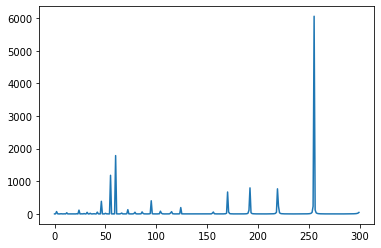

In [29]:
plt.plot(y[64])

In [18]:
sqrt = lambda v: complex(v, 0)**0.5
sqrt(4)

(2+0j)